In [2]:
from collections import Counter # se usará? la saqué del notebook "pandas introduccion"
import requests # se usará? la saqué del notebook "pandas introduccion"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport

from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

In [3]:
with requests.get(
    "https://docs.google.com/spreadsheets/d/1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0/export?format=csv"
) as r, open("fiufip_dataset.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)
        

In [4]:
import pandas as pd
df = pd.read_csv("fiufip_dataset.csv")

## Veamos de que consta el dataset provisto

In [5]:
df.head()

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
0,17,Palermo,empleado_provincial,39,universidad_3_anio,sin_matrimonio,2174,hombre,40,cristianismo,sin_familia,0,entretenimiento
1,17,Palermo,monotibutista,50,universidad_3_anio,matrimonio_civil,0,hombre,13,cristianismo,casado,0,directivo_gerente
2,13,Palermo,relacion_de_dependencia,38,4_anio,divorciado,0,hombre,40,cristianismo,sin_familia,0,limpiador
3,11,Palermo,relacion_de_dependencia,53,2_anio,matrimonio_civil,0,hombre,40,judaismo,casado,0,limpiador
4,17,Balvanera,relacion_de_dependencia,28,universidad_3_anio,matrimonio_civil,0,mujer,40,judaismo,casada,0,profesional_especializado


In [6]:
df.shape

(32561, 13)

## Comienzo de posibles preguntas

**¿Existe alguna relación entre las horas de trabajo registradas y el rol familiar registado?**

Realicemos un breve analisis de ambas features

In [7]:
df[['horas_trabajo_registradas','rol_familiar_registrado']].isnull().sum()

horas_trabajo_registradas    0
rol_familiar_registrado      0
dtype: int64

Dejo esta idea por aca

Obtengamos las horas promedio segun cada rol

In [8]:
pf = df.groupby('rol_familiar_registrado').agg(list)



In [9]:
pf['promedio'] = pf['horas_trabajo_registradas'].apply(np.mean)
pf = pf['promedio']

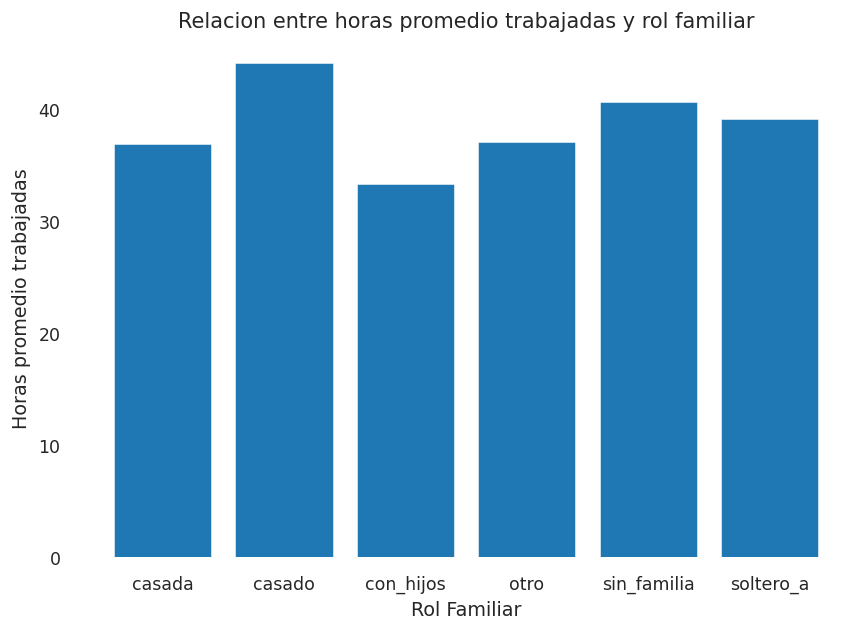

In [10]:
plt.figure(dpi=125)
plt.bar(pf.index,pf.values)
plt.xlabel("Rol Familiar")
plt.ylabel("Horas promedio trabajadas")
plt.title("Relacion entre horas promedio trabajadas y rol familiar")
plt.show()

Se observa una breve disminucion en las horas promedio trabajadas al tener hijos. Dudo mucho que esto sea util para algo

In [11]:
gente_por_trabajo = df['trabajo'].value_counts()
gente_por_trabajo

profesional_especializado    4140
reparador                    4099
directivo_gerente            4066
entretenimiento              3770
ventas                       3650
otros                        3295
inspector                    2002
transporte                   1597
limpiador                    1370
sector_primario               994
soporte_tecnico               928
seguridad                     649
servicio_domestico            149
ejercito                        9
Name: trabajo, dtype: int64

Aca me parece que los nulos, seria por que la persona no trabaja

In [12]:

gente_por_categoria_de_trabajo = df['categoria_de_trabajo'].value_counts()
gente_por_categoria_de_trabajo.sum()

30725

In [13]:
df.isnull().sum()

anios_estudiados                                 0
barrio                                         583
categoria_de_trabajo                          1836
edad                                             0
educacion_alcanzada                              0
estado_marital                                   0
ganancia_perdida_declarada_bolsa_argentina       0
genero                                           0
horas_trabajo_registradas                        0
religion                                         0
rol_familiar_registrado                          0
tiene_alto_valor_adquisitivo                     0
trabajo                                       1843
dtype: int64

Se puede ver que hay varios faltantes, lo raro seria que segun el dataset tributan, pero sin trabajo¡? ademas si les da verguenza pueden poner otros como opcion, por eso es raro

In [14]:
cantidad_por_educacion_alcanzada = df['educacion_alcanzada'].value_counts()
cantidad_por_educacion_alcanzada

4_anio                10501
5_anio                 7291
universidad_3_anio     5355
universidad_4_anio     1723
universidad_1_anio     1382
2_anio                 1175
universidad_2_anio     1067
1_anio                  933
7-8_grado               646
universiada_5_anio      576
9_grado                 514
3_anio                  433
universiada_6_anio      413
5-6_grado               333
1-4_grado               168
preescolar               51
Name: educacion_alcanzada, dtype: int64

Aca potencialmente podriamos reducir la cardinalidad agrupando en si termino el secuandario, si termino la facultad, etc

In [15]:
 df['estado_marital'].value_counts()

matrimonio_civil      14976
sin_matrimonio        10683
divorciado             4443
separado               1025
viudo_a                 993
pareja_no_presente      418
matrimonio_militar       23
Name: estado_marital, dtype: int64

Esta feature no se si tiene algo en cuanto a su cardinalidad interesante para decir, solo eso que habias marcado la inconsistencia de casado/casada

# ¿Cuanta gente tiene declaradas ganancias o perdidas en la bolsa argentina?

In [16]:
 (df['ganancia_perdida_declarada_bolsa_argentina'] != 0).value_counts()

False    28330
True      4231
Name: ganancia_perdida_declarada_bolsa_argentina, dtype: int64

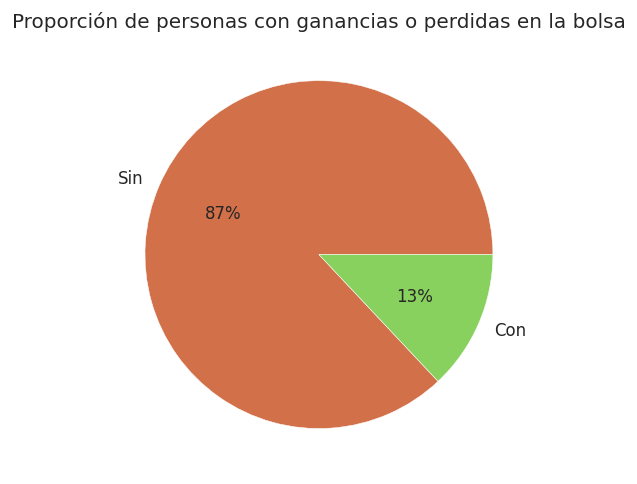

In [17]:
plt.figure(figsize=(6.4, 4.8), dpi=120)
plt.title('Proporción de personas con ganancias o perdidas en la bolsa')
plt.pie((df['ganancia_perdida_declarada_bolsa_argentina'] != 0).value_counts(), labels= ['Sin', 'Con'], colors=['#D17049',"#89D15E"],autopct='%1.0f%%')
plt.ylabel('')
plt.show()

Entoces el 87% declara no tener ganancias o perdidas en la bolsa. Dado que seria raro que el balance de justo 0, podriamos concluir que solo el 13% de los contribuyentes opera en la bolsa

## ¿Existe alguna relación entre el rol familiar del contribuyente y si opera en la bolsa de argentina?

Veamos primero la distribucion de los roles familiares entre los contribuyentes

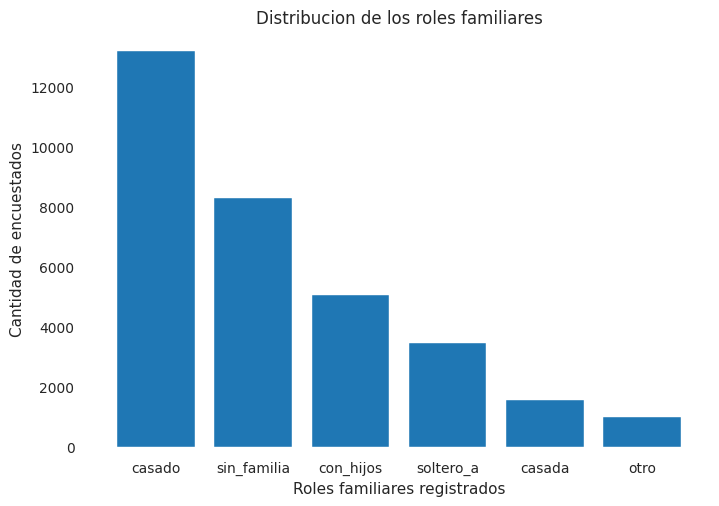

In [18]:
plt.figure(dpi=(100))
cantidad_de_encuestados_por_rol = (
    df['rol_familiar_registrado']
    .value_counts()
    .sort_values(ascending=False)
)
plt.bar(cantidad_de_encuestados_por_rol.index, cantidad_de_encuestados_por_rol.values)
plt.ylabel("Cantidad de encuestados")
plt.xlabel("Roles familiares registrados")
plt.title('Distribucion de los roles familiares')
plt.show()

Llama la atencion que existe una categoria casada y casada, distinguiendo por género, mientrás que soltero_a no hace esta distinción. Veamos la relacion de estas categorias, y tener declarado en la bolsa

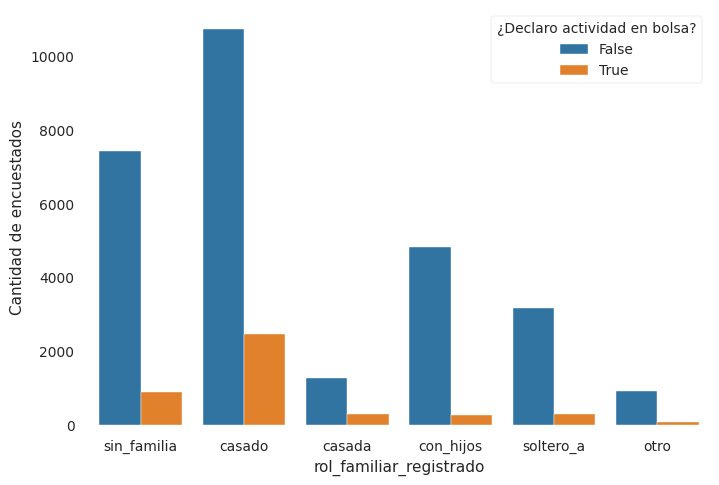

In [57]:
df['declaro_actividad_en_bolsa'] = df['ganancia_perdida_declarada_bolsa_argentina'] != 0
df['declaro_actividad_en_bolsa'].replace(False,0)
.plt.figure(dpi = (100))


bar_plot = sns.countplot(data=df, x='rol_familiar_registrado', hue='declaro_actividad_en_bolsa')
legend = bar_plot.get_legend()
legend.set_title('¿Declaro actividad en bolsa?')
labels = legend.texts
labels[0] = 'No'
labels[1] = 'Si'
bar_plot.set_ylabel('Cantidad de encuestados')




plt.show()

Ya se que habria que hacerlo porcentual, pero a priori no veo ninguna relacion que pueda ser interesante.

In [20]:
df.rol_familiar_registrado.value_counts(normalize=True)

casado         0.405178
sin_familia    0.255060
con_hijos      0.155646
soltero_a      0.105832
casada         0.048156
otro           0.030128
Name: rol_familiar_registrado, dtype: float64

## ¿Existe alguna relación entre declarar altos ingresos y operar en la bolsa argentina?

Veamos que sucede con quienes declaran altos ingresos

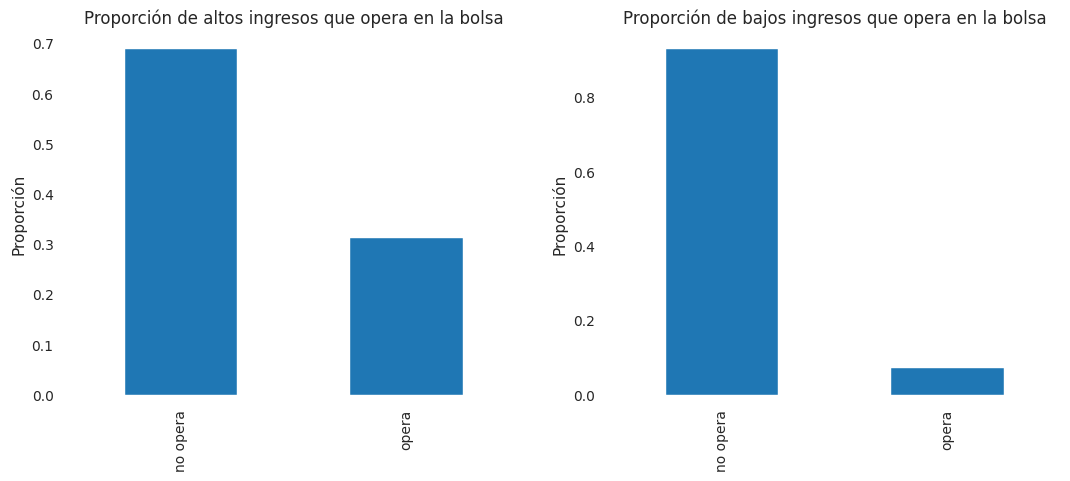

In [21]:
df['opera_en_bolsa'] = df['ganancia_perdida_declarada_bolsa_argentina'] != 0
df['gana_en_bolsa'] = df['ganancia_perdida_declarada_bolsa_argentina'] > 0
df['opera_en_bolsa'] = df['opera_en_bolsa'].replace({True : 'opera',False:'no opera'})
df['gana_en_bolsa'] = df['gana_en_bolsa'].replace({True : 'gana',False:'no_gana'})
dataset_altos_ingresos = df[df.tiene_alto_valor_adquisitivo != 0]
dataset_bajos_ingresos = df[df.tiene_alto_valor_adquisitivo == 0]



fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)


dataset_altos_ingresos.opera_en_bolsa.value_counts(normalize=True).plot(kind='bar', ax=axes[0])
axes[0].set_title("Proporción de altos ingresos que opera en la bolsa")
axes[0].set_ylabel("Proporción")

bar_plot = dataset_bajos_ingresos.opera_en_bolsa.value_counts(normalize=True).plot(kind='bar', ax=axes[1])
axes[1].set_title("Proporción de bajos ingresos que opera en la bolsa")
axes[1].set_ylabel("Proporción")



plt.show()


Aca puede haber una relación interesante, porque el 30% de los que declaran altos ingresos operan en la bolsa. Veamos si declaran una ganancia positiva

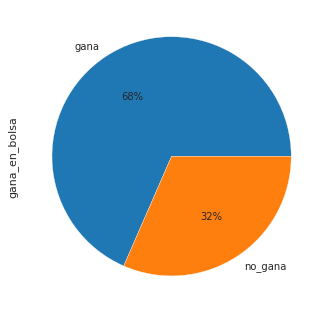

In [22]:
dataset_altos_que_operan = dataset_altos_ingresos[dataset_altos_ingresos.opera_en_bolsa == 'opera']
dataset_altos_que_operan.gana_en_bolsa.value_counts(normalize=True).plot(kind='pie',autopct='%1.0f%%')
plt.show()


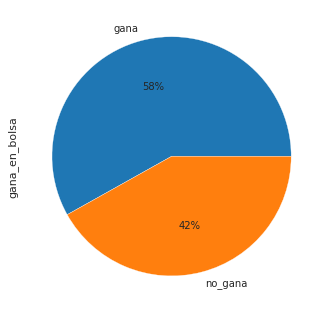

In [23]:
dataset_bajos_que_operan = dataset_bajos_ingresos[dataset_bajos_ingresos.opera_en_bolsa == 'opera']
dataset_bajos_que_operan.gana_en_bolsa.value_counts(normalize=True).plot(kind='pie',autopct='%1.0f%%')
plt.show()

# Hago intento del pipeline en base a esta info

In [24]:

#pred[df.trabajo == 'directivo_gerente'] = 1
df['alto'] = (df['ganancia_perdida_declarada_bolsa_argentina'] != 0) 
accuracy_score(df.tiene_alto_valor_adquisitivo,df.alto)


0.7797364945794049

Jeje, tirando un poco por tirar casi llego al 80% correcto, igual tampoco es mucho contando que arranque en 75%...

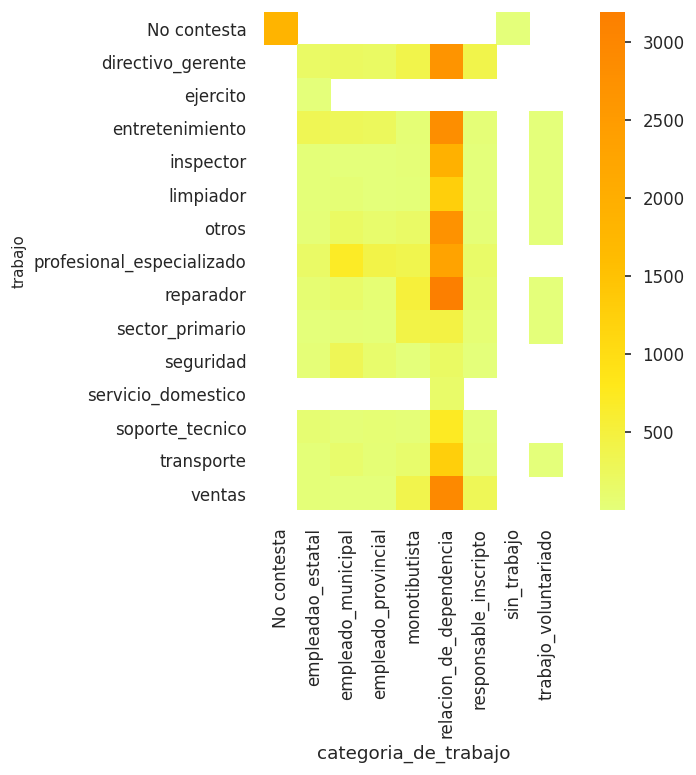

In [25]:
df['trabajo'] = df['trabajo'].replace(np.nan,'No contesta')
df['categoria_de_trabajo'] = df['categoria_de_trabajo'].replace(np.nan,'No contesta')
tabla_pivot = pd.pivot_table(df,values='edad',index='trabajo',columns='categoria_de_trabajo',aggfunc='count').sort_index()
plt.figure(dpi=120)
plt.ylabel("Trabajo", fontsize=9)
sns.heatmap(tabla_pivot, square=True, cmap="Wistia")
plt.xticks(rotation = 90)
plt.show()


**Mi idea aca era hacer un heatmap, que muestre que la cantidad de gente que no contesto a categoria_trabajo es casi igual a la que no contesto trabajo, el proyecto no prospero. Tuve mas que nada problemas en la pivot table. Igual se visualiza lo que te digo si te fijas y se podrian poner algunas conclusiones adicionales**

** Hasta aca llegue, para mi habria que seguir verificando los valores numericos y que sean correctos, y luego si hay alguna feature en particular que valga la pena resaltar algo, como con los barrios (podemos revisar el profiling para ver si hay alguna idea). Otra cosa que falto es chequear valores falopa (esta en el otro notebook) y remplazarlo por nulos. Intente ir "contando" una historia para justificar cada cosa que me iba fijando. Lo mas complicado es claramente graficar, centremosnos en eso. Aca ya medio que veo la correlacion de dos variables, no lo veo mal porque conecta bien con fijarse por los nulos. **

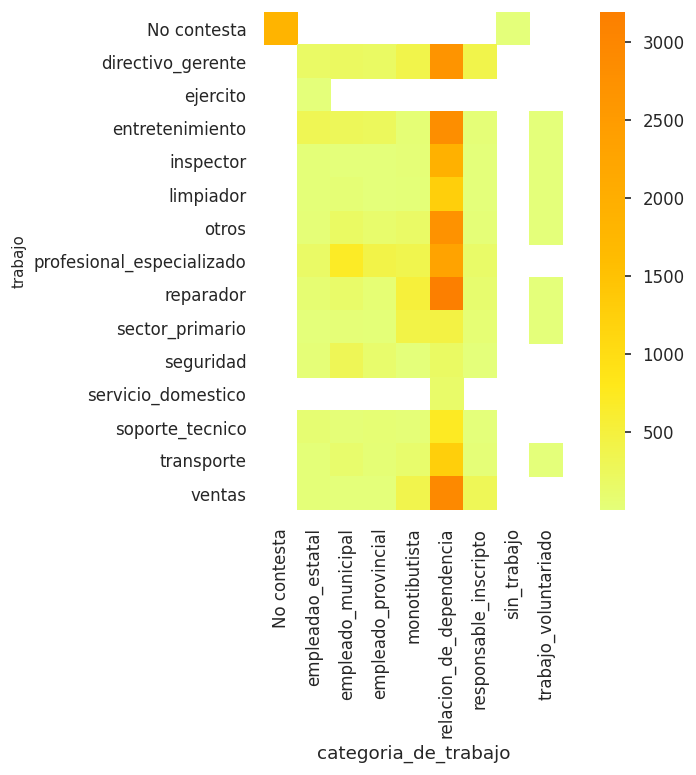

In [26]:
df['trabajo'] = df['trabajo'].replace(np.nan,'No contesta')
df['categoria_de_trabajo'] = df['categoria_de_trabajo'].replace(np.nan,'No contesta')
tabla_pivot = pd.pivot_table(df,values='edad',index='trabajo',columns='categoria_de_trabajo',aggfunc='count').sort_index()
plt.figure(dpi=120)
plt.ylabel("Trabajo", fontsize=9)
sns.heatmap(tabla_pivot, square=True, cmap="Wistia")
plt.xticks(rotation = 90)
plt.show()


**Mi idea aca era hacer un heatmap, que muestre que la cantidad de gente que no contesto a categoria_trabajo es casi igual a la que no contesto trabajo, el proyecto no prospero. Tuve mas que nada problemas en la pivot table. Igual se visualiza lo que te digo si te fijas y se podrian poner algunas conclusiones adicionales**

** Hasta aca llegue, para mi habria que seguir verificando los valores numericos y que sean correctos, y luego si hay alguna feature en particular que valga la pena resaltar algo, como con los barrios (podemos revisar el profiling para ver si hay alguna idea). Otra cosa que falto es chequear valores falopa (esta en el otro notebook) y remplazarlo por nulos. Intente ir "contando" una historia para justificar cada cosa que me iba fijando. Lo mas complicado es claramente graficar, centremosnos en eso. Aca ya medio que veo la correlacion de dos variables, no lo veo mal porque conecta bien con fijarse por los nulos. **

## ¿Qué sucede con los valores nulos en las features 'categoría de trabajo' y 'trabajo'? ¿Tiene alguna relación?

Como habiamos mencionado anteriormente, la cantidad de nulos en estas features es de un número parecido. Veamos si existe alguna relación que se pueda observar. Comencemos analizando los trabajos

Podemos observar que no figura entre las posibles opciones estar desempleado, con lo cual quizas no estaba la opción a la hora de la construcción del dataset. Remplacemos los NaN por 'No contesta', luego veremos si podemos obtener más información de quienes no contestaron

## ¿Qué sucede con los valores nulos en las features 'categoría de trabajo' y 'trabajo'? ¿Tiene alguna relación?

Como habiamos mencionado anteriormente, la cantidad de nulos en estas features es de un número parecido. Veamos si existe alguna relación que se pueda observar. Comencemos analizando los trabajos

### ¿Qué trabajos hay y como se distribuyen?

In [27]:
df['trabajo'].value_counts(dropna=False)

profesional_especializado    4140
reparador                    4099
directivo_gerente            4066
entretenimiento              3770
ventas                       3650
otros                        3295
inspector                    2002
No contesta                  1843
transporte                   1597
limpiador                    1370
sector_primario               994
soporte_tecnico               928
seguridad                     649
servicio_domestico            149
ejercito                        9
Name: trabajo, dtype: int64

Podemos observar que no figura entre las posibles opciones estar desempleado, con lo cual quizas no estaba la opción a la hora de la construcción del dataset. Remplacemos los NaN por 'No contesta', luego veremos si podemos obtener más información de quienes no contestaron

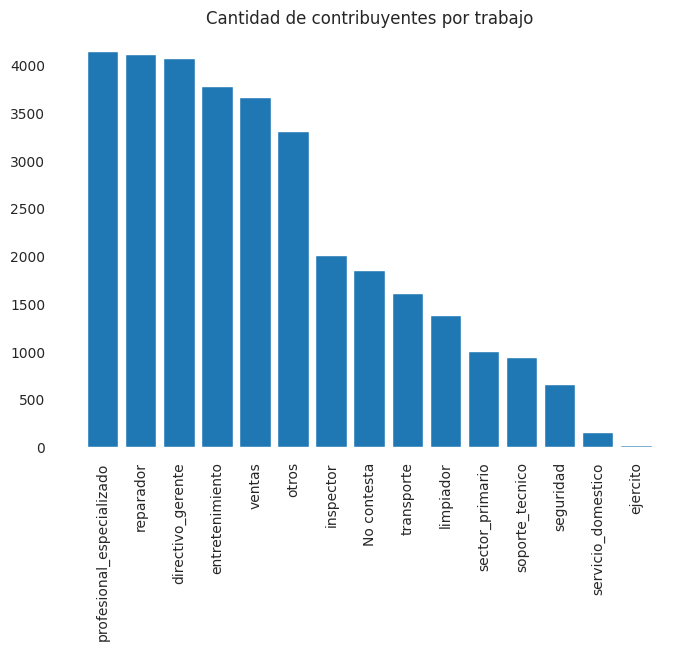

In [28]:
df['trabajo'] = df['trabajo'].replace(np.nan,'No contesta')
plt.figure(dpi = 100)
cantidad_por_trabajo = df['trabajo'].value_counts()
plt.bar(cantidad_por_trabajo.index,cantidad_por_trabajo.values)
plt.title("Cantidad de contribuyentes por trabajo")
plt.xticks(rotation = 90)
plt.show()

El gráfico es horroroso

### ¿Que categorias de trabajo hay y como se distribuyen?

In [29]:
df['categoria_de_trabajo'].value_counts(dropna=False)

relacion_de_dependencia    22696
monotibutista               2541
empleado_municipal          2093
No contesta                 1836
empleado_provincial         1298
responsable_inscripto       1116
empleadao_estatal            960
trabajo_voluntariado          14
sin_trabajo                    7
Name: categoria_de_trabajo, dtype: int64

Se puede ver que hay nulos, remplacemoslo por 'No contesta' de nuevo

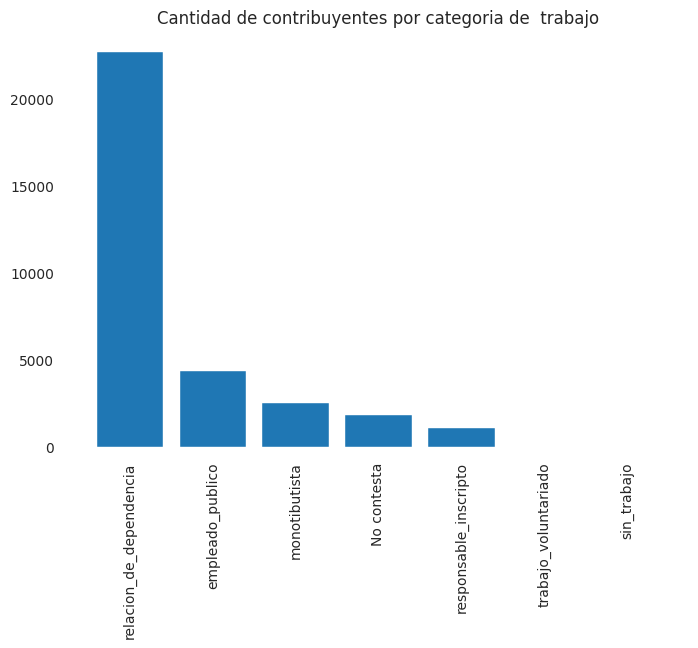

In [30]:
def generalizar_empleados_publicos(categoria):
    if categoria in ['empleado_municipal','empleado_provincial','empleadao_estatal']:
        return 'empleado_publico'
    return categoria
df['categoria_de_trabajo'] = df['categoria_de_trabajo'].replace(np.nan,'No contesta')
df['categoria_de_trabajo'] = df['categoria_de_trabajo'].apply(generalizar_empleados_publicos)
plt.figure(dpi = 100)
cantidad_por_trabajo = df['categoria_de_trabajo'].value_counts()
plt.bar(cantidad_por_trabajo.index,cantidad_por_trabajo.values)
plt.title("Cantidad de contribuyentes por categoria de  trabajo")
plt.xticks(rotation = 90)
plt.show()

**Aca al fin no se que hacer con la relacion. quizas simplemente mostrar que los que faltan en una son los que faltan en la otra** 

Centremonos en las personas que no contestaron ninguna de las dos categorias anteriores

In [31]:
dataset_sin_respuestas = df[df['trabajo'] == 'No contesta'] 
dataset_sin_respuestas = dataset_sin_respuestas[dataset_sin_respuestas['categoria_de_trabajo'] == 'No contesta']
dataset_sin_respuestas.tiene_alto_valor_adquisitivo.value_counts(normalize=True) * 100

0    89.59695
1    10.40305
Name: tiene_alto_valor_adquisitivo, dtype: float64

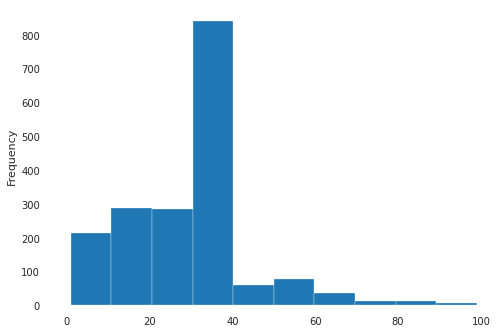

In [32]:
dataset_sin_respuestas.horas_trabajo_registradas.plot(kind='hist',bins=10)
plt.show()

In [33]:
(dataset_sin_respuestas.ganancia_perdida_declarada_bolsa_argentina != 0)

27       False
61       False
69       False
77       False
106       True
         ...  
32530    False
32531    False
32539    False
32541    False
32542    False
Name: ganancia_perdida_declarada_bolsa_argentina, Length: 1836, dtype: bool

# Religión

In [34]:
df['religion'].value_counts(normalize=True)*100

cristianismo    85.427352
judaismo         9.594300
budismo          3.190934
ateismo          0.955130
otro             0.832284
Name: religion, dtype: float64

## Religion y valor adquisitvo

In [35]:
cristianos = df[df.religion == 'cristianismo']
cristianos['tiene_alto_valor_adquisitivo'].value_counts(normalize=True)

0    0.74414
1    0.25586
Name: tiene_alto_valor_adquisitivo, dtype: float64

In [36]:
judios = df[df.religion == 'judaismo']
judios['tiene_alto_valor_adquisitivo'].value_counts(normalize=True)

0    0.87612
1    0.12388
Name: tiene_alto_valor_adquisitivo, dtype: float64

In [37]:
budistas = df[df.religion == 'budismo']
budistas['tiene_alto_valor_adquisitivo'].value_counts(normalize=True)

0    0.73436
1    0.26564
Name: tiene_alto_valor_adquisitivo, dtype: float64

In [38]:
ateos = df[df.religion == 'ateismo']
ateos['tiene_alto_valor_adquisitivo'].value_counts(normalize=True)

0    0.884244
1    0.115756
Name: tiene_alto_valor_adquisitivo, dtype: float64

## Religion y edad

<AxesSubplot:ylabel='Frequency'>

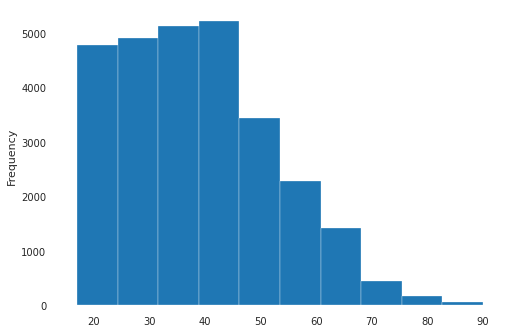

In [39]:
cristianos['edad'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

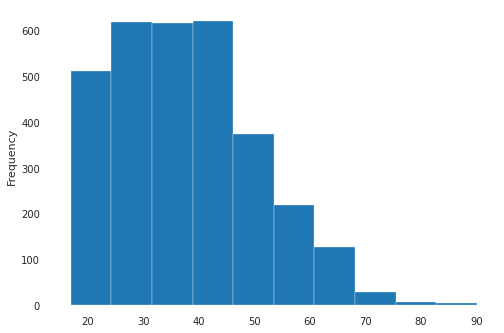

In [40]:
judios['edad'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

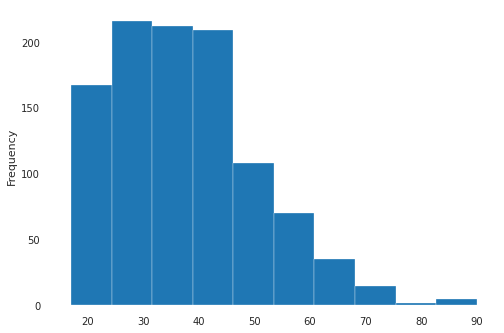

In [41]:
budistas['edad'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

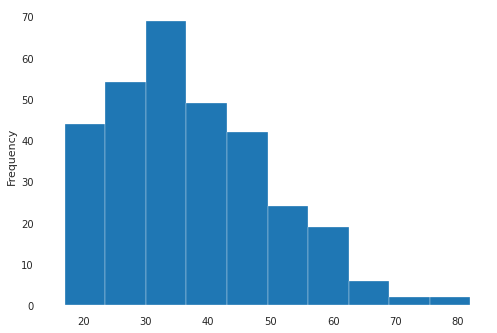

In [42]:
ateos['edad'].plot(kind='hist')

## Religion y horas trabajadas

<AxesSubplot:ylabel='Frequency'>

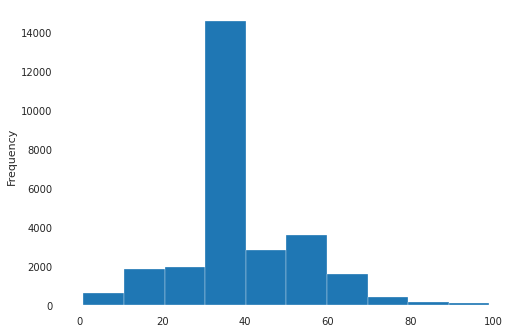

In [43]:
cristianos['horas_trabajo_registradas'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

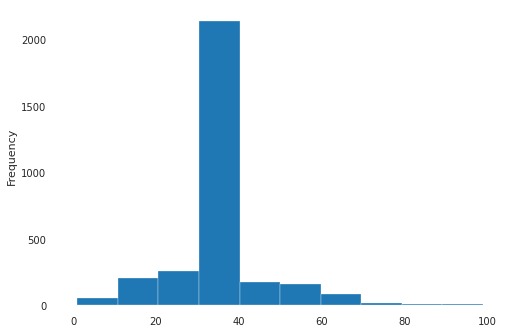

In [44]:
judios['horas_trabajo_registradas'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

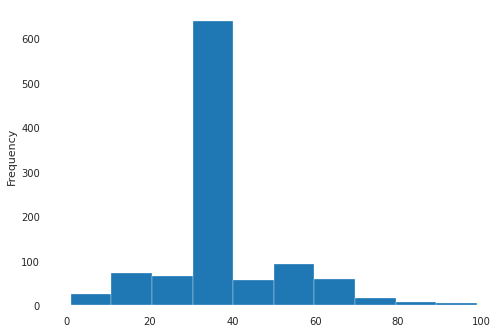

In [45]:
budistas['horas_trabajo_registradas'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

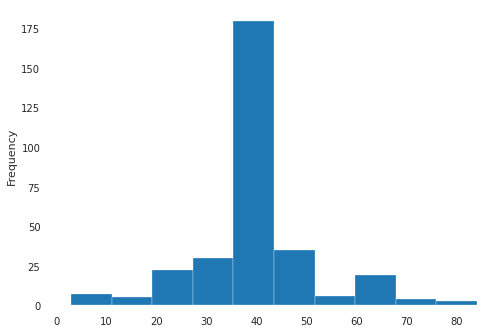

In [46]:
ateos['horas_trabajo_registradas'].plot(kind='hist')

## Religion y operar en la bolsa

In [47]:
(cristianos['ganancia_perdida_declarada_bolsa_argentina'] != 0).value_counts(normalize=True)

False    0.865006
True     0.134994
Name: ganancia_perdida_declarada_bolsa_argentina, dtype: float64

In [48]:
(judios['ganancia_perdida_declarada_bolsa_argentina'] != 0).value_counts(normalize=True)

False    0.908771
True     0.091229
Name: ganancia_perdida_declarada_bolsa_argentina, dtype: float64

In [49]:
(budistas['ganancia_perdida_declarada_bolsa_argentina'] != 0).value_counts(normalize=True)

False    0.868142
True     0.131858
Name: ganancia_perdida_declarada_bolsa_argentina, dtype: float64

In [50]:
(ateos['ganancia_perdida_declarada_bolsa_argentina'] != 0).value_counts(normalize=True)

False    0.900322
True     0.099678
Name: ganancia_perdida_declarada_bolsa_argentina, dtype: float64

## Religion y trabajos

<AxesSubplot:>

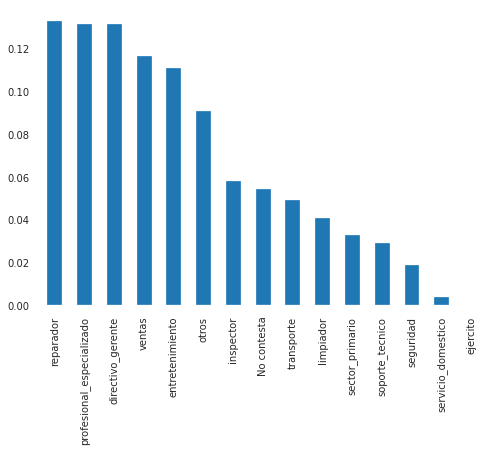

In [51]:
cristianos.trabajo.value_counts(normalize=True).plot(kind='bar')

<AxesSubplot:>

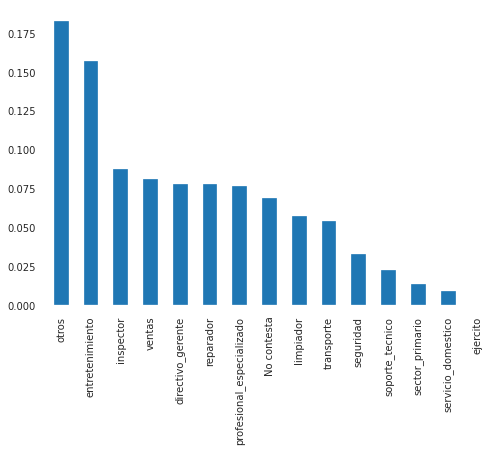

In [52]:
judios.trabajo.value_counts(normalize=True).plot(kind='bar')

<AxesSubplot:>

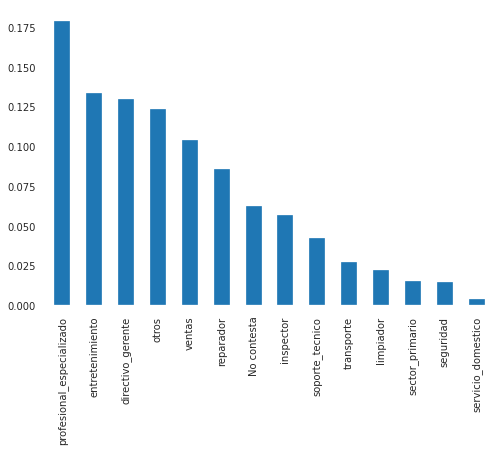

In [53]:
budistas.trabajo.value_counts(normalize=True).plot(kind='bar')

## La gente mas grande, ¿Suele llegar a puestos gerenciales? ¿Qué sucede con los profesionaes especializados?


Veamos primero que sucede en puestos gerenciales

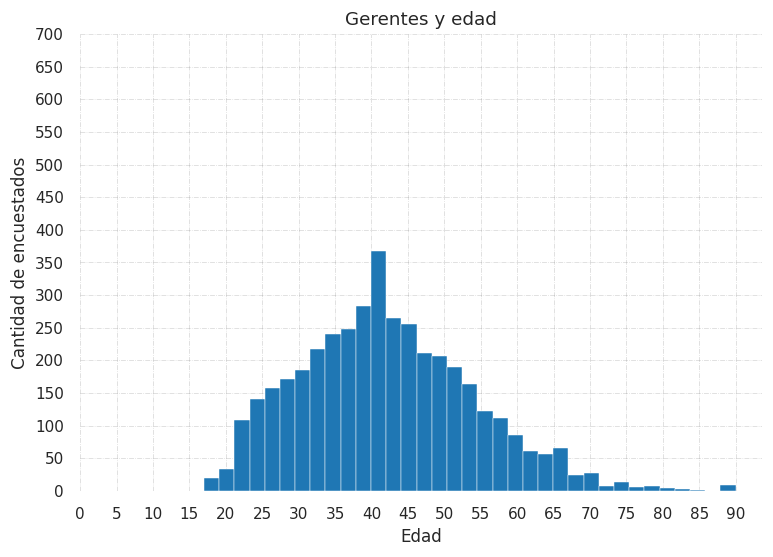

In [54]:
gerenciales = df[df.trabajo == 'directivo_gerente']
plt.figure(dpi=110)
bins_deseados = int(gerenciales.edad.nunique()/2)
plt.hist(gerenciales.edad, bins=bins_deseados, label="Edad")

plt.title("Gerentes y edad")
plt.ylabel("Cantidad de encuestados")
plt.xlabel("Edad")
plt.xticks(np.arange(0,95, 5))
plt.yticks(np.arange(0,750, 50))
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)

plt.show()

In [66]:
df[(df.rol_familiar_registrado == 'soltero_a') & (df.estado_marital == 'sin_matrimonio')].shape

(881, 19)

In [67]:
df[(df.rol_familiar_registrado == 'sin_familia') & (df.estado_marital == 'sin_matrimonio')].shape

(4706, 19)

In [65]:
df['estado_marital'].value_counts()

matrimonio_civil      14976
sin_matrimonio        10683
divorciado             4443
separado               1025
viudo_a                 993
pareja_no_presente      418
matrimonio_militar       23
Name: estado_marital, dtype: int64

<AxesSubplot:>

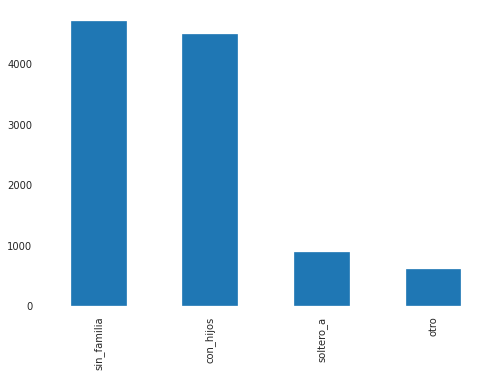

In [68]:
df[(df.estado_marital == 'sin_matrimonio')].rol_familiar_registrado.value_counts().plot(kind='bar')

<AxesSubplot:>

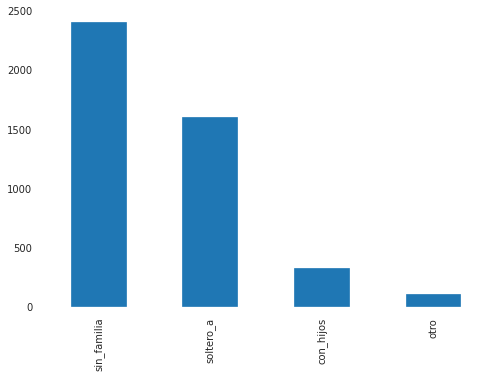

In [69]:
df[(df.estado_marital == 'divorciado')].rol_familiar_registrado.value_counts().plot(kind='bar')

## ¿las mujeres en proporcion son menos en los trabajos tendientes a tener altos ingresos?

In [71]:
gerentes = df[df.trabajo == 'seguridad']
gerentes['genero'].value_counts(normalize=True)#.plot(kind='bar')
#plt.show()

hombre    0.882897
mujer     0.117103
Name: genero, dtype: float64

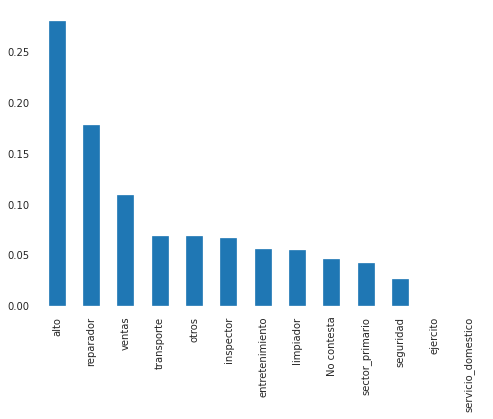

In [75]:
trabajos_hombres = df[df.genero == 'hombre']
trabajos_hombres = trabajos_hombres.replace({'directivo_gerente':'alto','profesional_especializado':'alto','soporte_tecnico':'alto'})

trabajos_hombres['trabajo'].value_counts(normalize=True).plot(kind='bar')
plt.show()

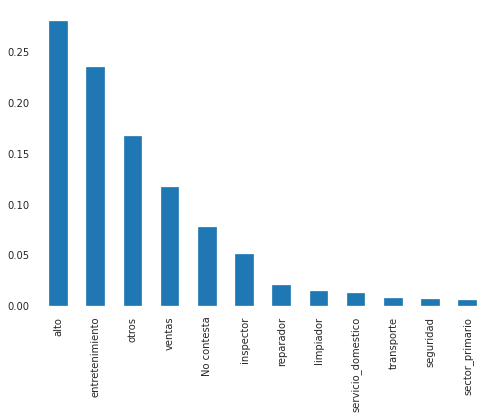

In [74]:
trabajos_mujeres = df[df.genero == 'mujer']
trabajos_mujeres = trabajos_mujeres.replace({'directivo_gerente':'alto','profesional_especializado':'alto','soporte_tecnico':'alto'})
trabajos_mujeres['trabajo'].value_counts(normalize=True).plot(kind='bar')
plt.show()

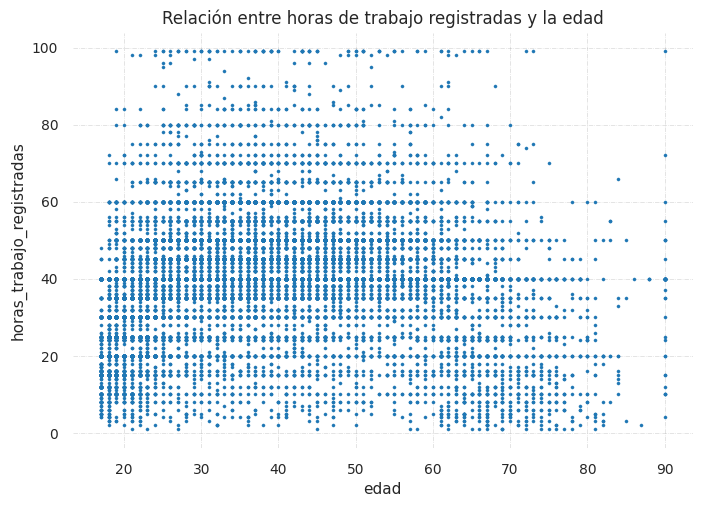

In [17]:
plt.figure(dpi=(100))
plt.scatter(
    x=df['edad'],
    y=df['horas_trabajo_registradas'],
    s=5,
)
plt.ylabel("horas_trabajo_registradas")
plt.xlabel("edad")
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)
plt.title('Relación entre horas de trabajo registradas y la edad')
plt.show()
#Box plot, dividir por rangos la edad

<AxesSubplot:ylabel='Frequency'>

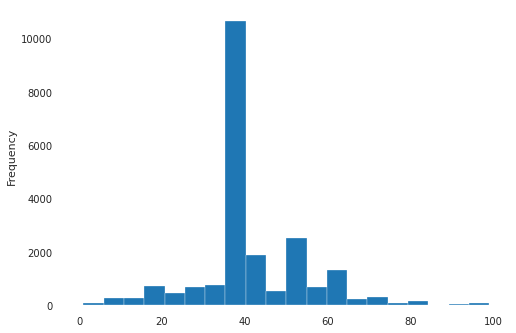

In [58]:
pf = df[df.genero == 'hombre']
pf['horas_trabajo_registradas'].plot(kind='hist',bins=20)

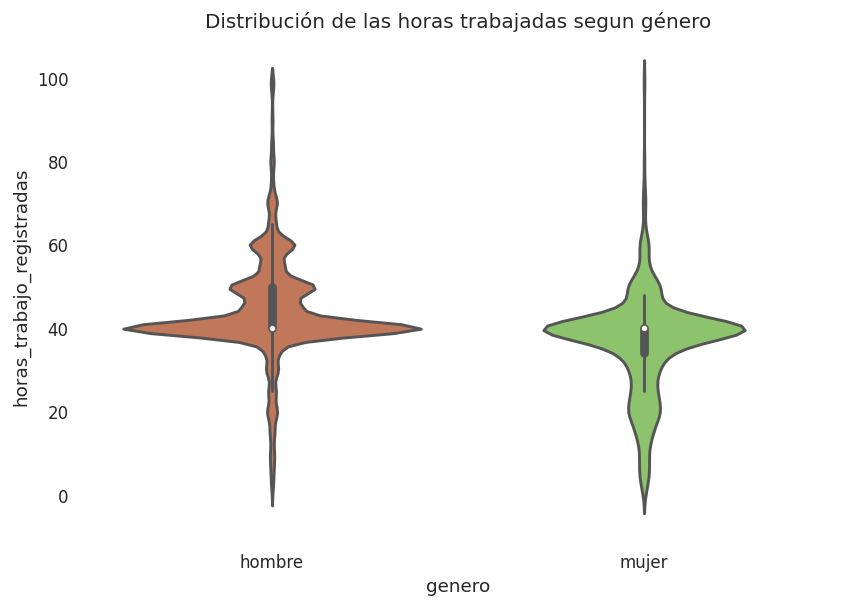

In [51]:
plt.figure(dpi=120)
pf = df[df.estado_marital == 'matrimonio_civil']
plt.title("Distribución de las horas trabajadas segun género")
sns.violinplot(
    data=pf,
    y='horas_trabajo_registradas',
    x='genero',
    palette=['#D17049', "#89D15E"],
)

plt.show()

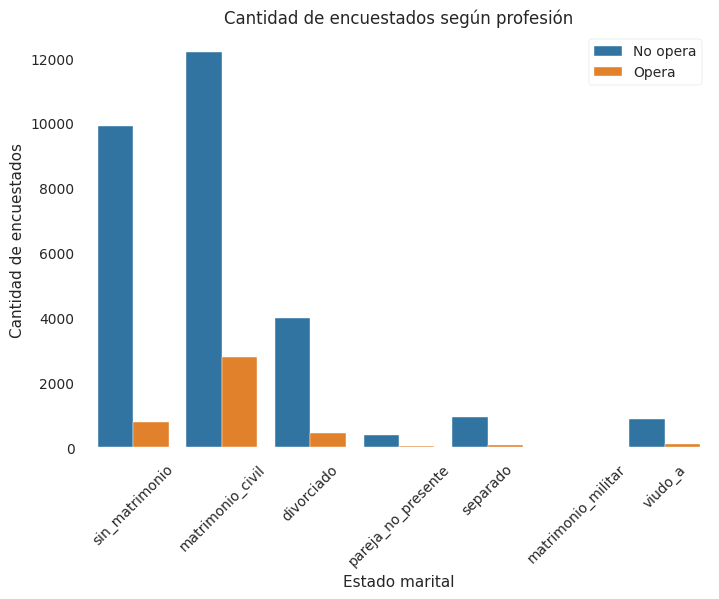

In [35]:
df['declaro_actividad_en_bolsa'] = df['suma_declarada_bolsa_argentina'] != 0
df['declaro_actividad_en_bolsa'].replace(False,0)

plt.figure(dpi = (100))
sns.countplot(
   data=df, x='estado_marital', hue='declaro_actividad_en_bolsa'
)
plt.legend(labels=['No opera','Opera'])
plt.ylabel("Cantidad de encuestados")
plt.xlabel("Estado marital")
plt.title("Cantidad de encuestados según profesión")
plt.xticks(rotation=45)
plt.show()



plt.show()

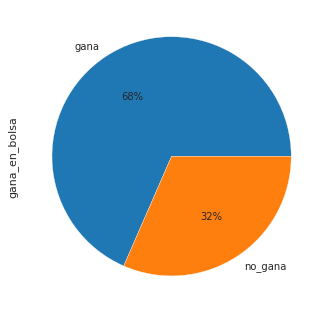

In [38]:
dataset_altos_que_operan = dataset_altos_ingresos[dataset_altos_ingresos.opera_en_bolsa == 'opera']
dataset_altos_que_operan.gana_en_bolsa.value_counts(normalize=True).plot(kind='pie',autopct='%1.0f%%')
plt.show()


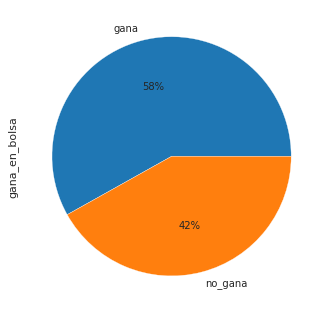

In [39]:
dataset_bajos_que_operan = dataset_bajos_ingresos[dataset_bajos_ingresos.opera_en_bolsa == 'opera']
dataset_bajos_que_operan.gana_en_bolsa.value_counts(normalize=True).plot(kind='pie',autopct='%1.0f%%')
plt.show()